In [3]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
from skimage import morphology, filters, measure, restoration
from skimage.io import imread

In [4]:
def custom_imread(path):
    a = plt.imread(path)
#     a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    return a

### Important definitions

In [5]:
# Path to cage pics (depth not currently used)
cagePath = os.path.join(os.path.expanduser('~'),'Downloads','samples','subtract_data','no_mouse','pic')
# Path to mouse images (pics and depth and normalized)
mousePath = os.path.join(os.path.expanduser('~'),'Downloads','samples','subtract_data','mouse')
# Frame number to use
FRAME_CAGE = 1
FRAME_MOUSE = 1329

Get the images

In [9]:
cageIm = []
mouseIm = []
mouseDepth = []
mouseNorm = []
for stream in range(4):
    file =  's_' + str(stream+1) + '_f_' + str(FRAME_MOUSE) + '.png'
    mouseIm.append(custom_imread(mousePath+'/pic_'+file))
    mouseNorm.append(custom_imread(mousePath+'/depth_normalized_' + file))
    mouseDepth.append(custom_imread(mousePath+'/depth_' + file))
    file =  'pic_s_' + str(stream+1) + '_f_' + str(FRAME_CAGE) + '.png'
    cageIm.append(custom_imread(cagePath+'/'+file))

In [10]:
def plot_helper(ax, im, title=None, cmap='gray'):
    if title:
        ax.set_title(title)
    ax.imshow(im, cmap=cmap)

In [11]:
def filter_subt(im):
#     im = restoration.denoise_nl_means(im, patch_size=9, h=0.3, patch_distance=7, multichannel=False)
    im = morphology.opening(im, np.ones((3,3)))
    return im

In [12]:
def filter_mask(im):
    im = morphology.closing(im, np.ones((3,3)))
    return im

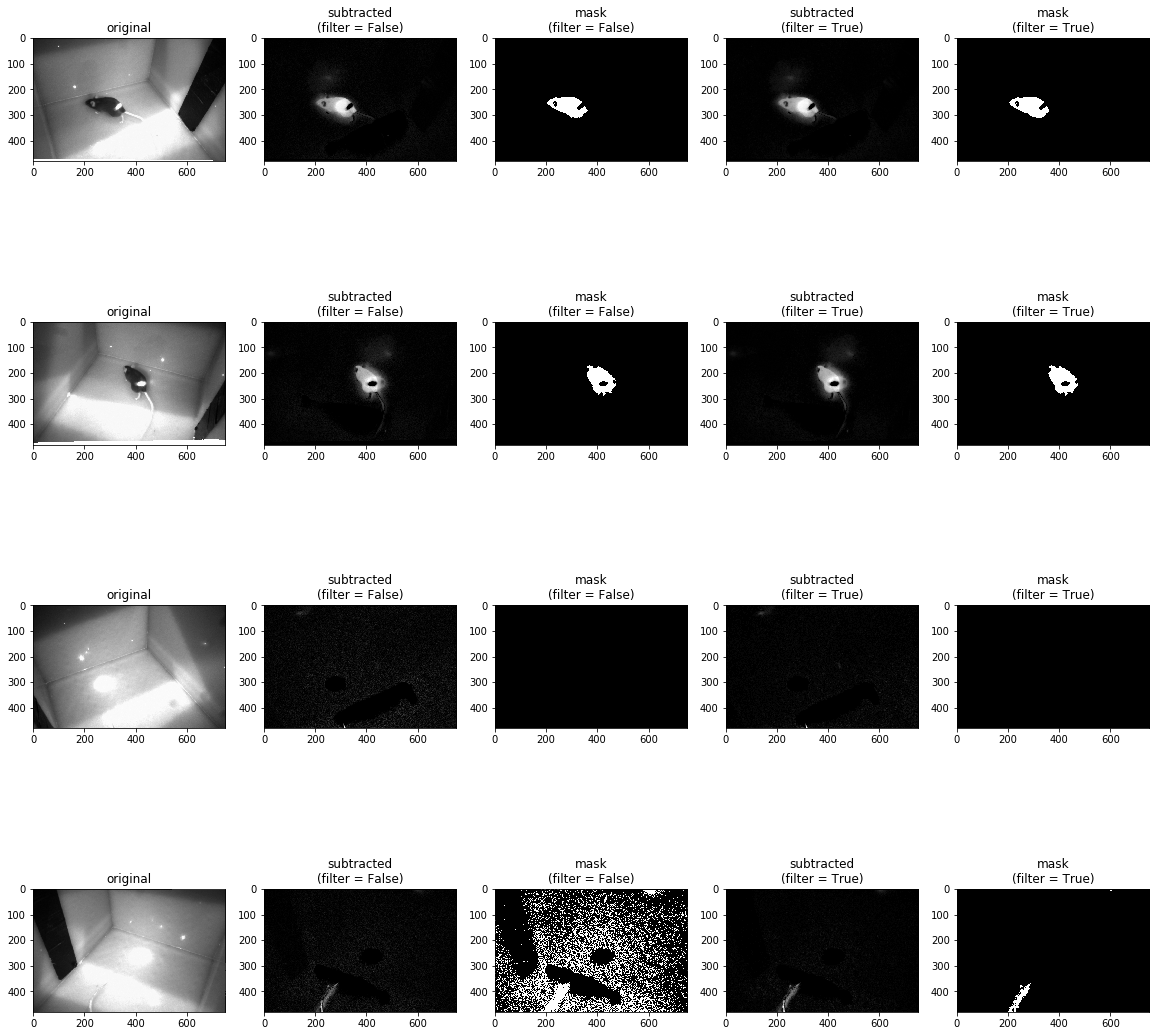

In [14]:
masks = []
f,axes = plt.subplots(ncols=5, nrows=len(mouseIm), figsize=(20,20))
for i,im in enumerate(mouseIm):
    plot_helper(axes[i][0], im, 'original')
    # For convenience, compare filtered and not filtered.
    for j,do_filter in enumerate([False, True]):
        subt = np.abs(im - cageIm[i])
        if do_filter:
            subt = filter_subt(subt)
        otsu = filters.threshold_otsu(subt)
        # A very low threshold means there's no significant bright spots, i.e. no mouse
        if otsu > 0.01:
            mask = subt > otsu
        else:
            mask = subt * 0.
        # Only want the mask of the filtered
        if do_filter:
            masks.append(mask)
        plot_helper(axes[i][j*2+1], subt, 'subtracted\n(filter = {})'.format(do_filter))
        plot_helper(axes[i][j*2+2], mask, 'mask\n(filter = {})'.format(do_filter))
plt.show()

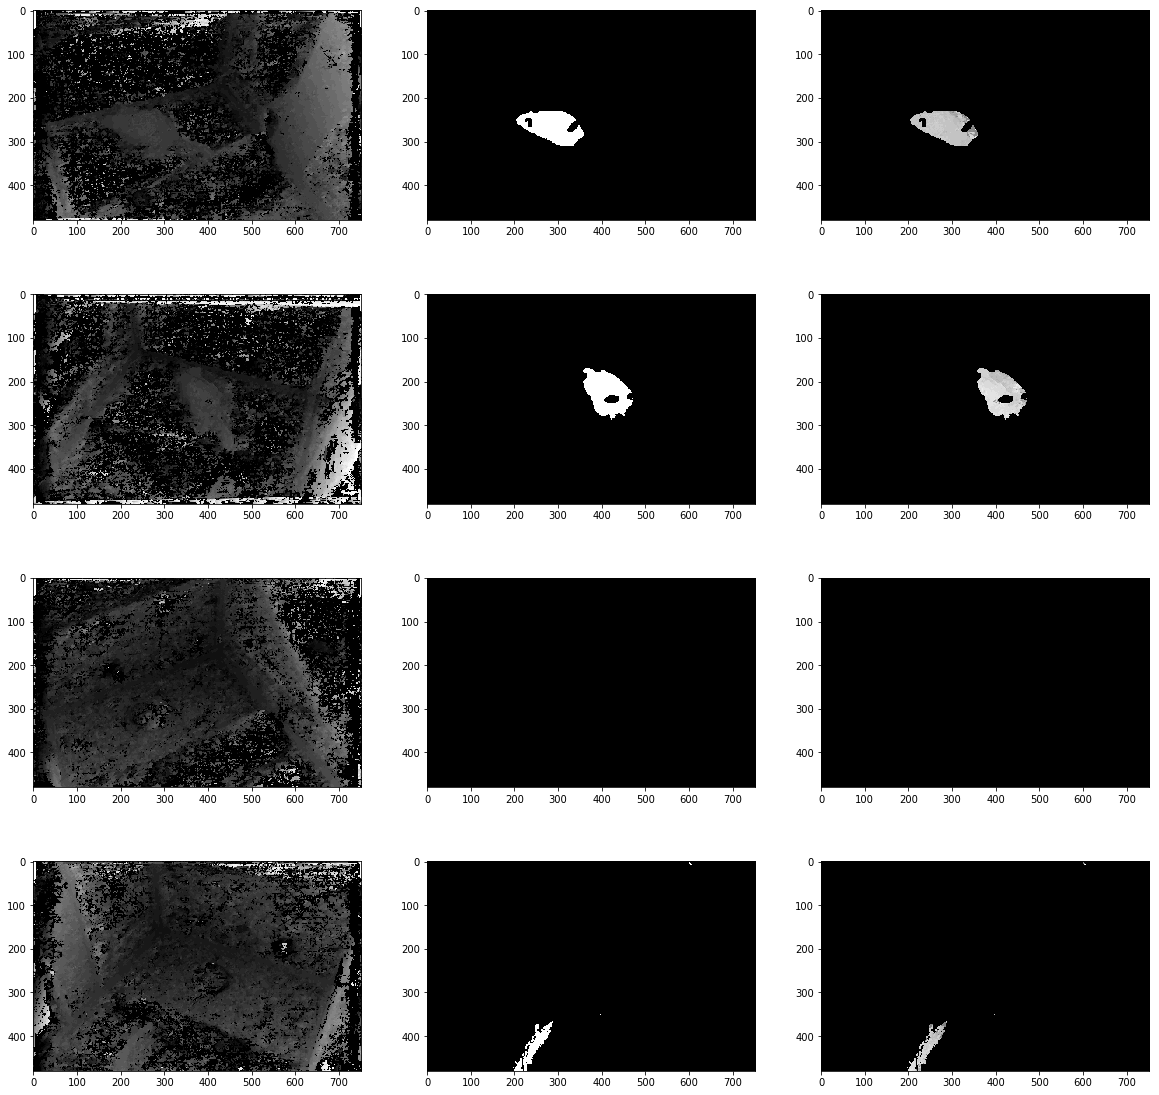

In [41]:
f,axes = plt.subplots(ncols=3, nrows=len(mouseIm), figsize=(20,20))
for i in range(len(mouseDepth)):
    axes[i][0].imshow(mouseNorm[i], cmap = 'gray')
    axes[i][1].imshow(masks[i], cmap = 'gray')
    masked = mouseNorm[i] * masks[i]
    axes[i][2].imshow(masked, cmap = 'gray')
    plt.imsave(mousePath + '/../out/depth_s_' + str(i+1) + '_f_' + str(frame) + '.png', masked, cmap = 'gray')
    plt.imsave(mousePath + '/../out/depth_normalized_s_' + str(i+1) + '_f_' + str(frame) + '.png', masked, cmap = 'gray', vmin=0, vmax=1)
plt.show()